# Spectral Graph TheoryX

### Hieu Q Nguyen | University of Waterloo | Co-op Fall 2018

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#from graph_tool.all import *
#from mpl_toolkits.basemap import Basemap
from pygsp import graphs, filters, plotting
import networkx as nx
import sklearn
from sklearn import datasets, decomposition
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (13, 7)
tol = 1e-10
plotting.BACKEND = "matplotlib"

In [2]:
sns.set_style('darkgrid')
sns.set_palette('colorblind')

# 1. Graph Construction

In [29]:
G = graphs.Community(N=300, Nc=7)
print(f'{G.N} nodes, {G.Ne} edges')

2018-11-24 14:36:49,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.942830956382712


300 nodes, 1657 edges


In [30]:
print(G.N)
print(G.Ne)

300
1657


In [31]:
print(G.is_connected())
print(G.is_directed())

False
False


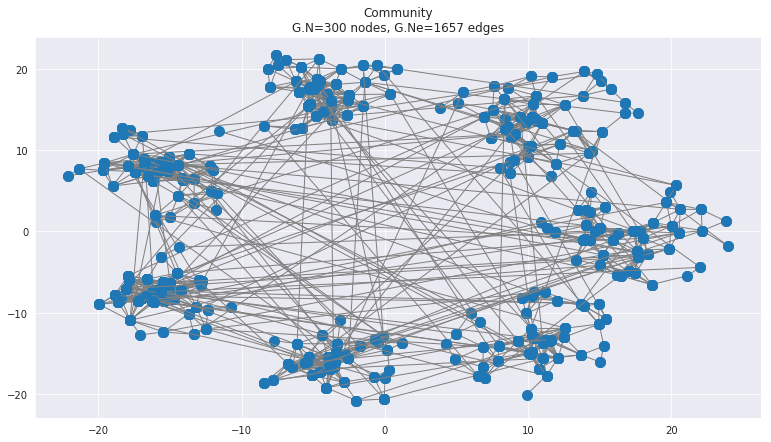

In [32]:
G.plot()

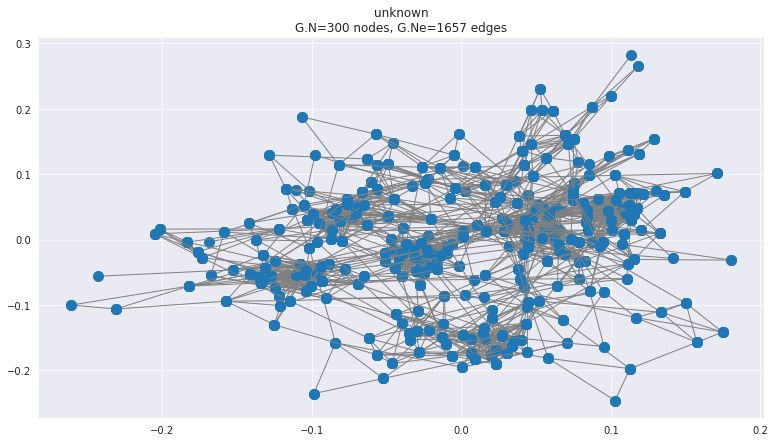

In [33]:
G2 = graphs.Graph(G.W)
G2.set_coordinates(kind='spring') #here with a spring based algorithm
G2.plot()

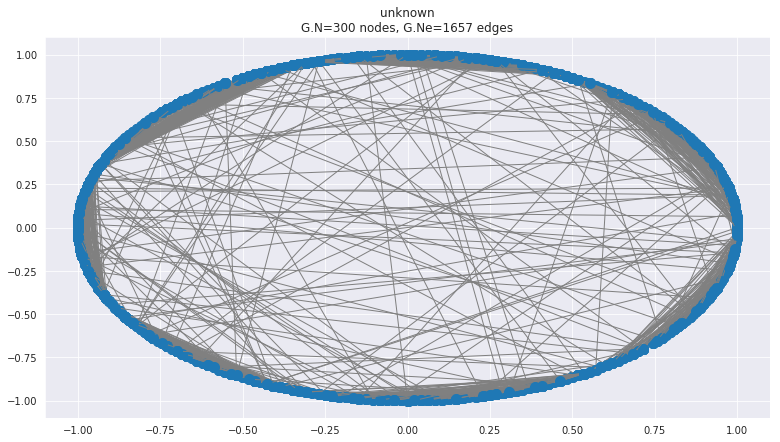

In [34]:
G2 = graphs.Graph(G.W)
G2.set_coordinates(kind='ring2D') #here with a spring based algorithm
G2.plot()

In [21]:
v_in, v_out, weights = G.get_edge_list()
print(v_in.shape, v_out.shape, weights.shape)

(273,) (273,) (273,)


graphs can also be constructed from a set of points in $\mathbb{R}^d$.

Let $\mathbf{X}$ be a data matrix $\mathbf{X} = [\mathbf{x}_1, \ldots, \mathbf{x}_N]^\intercal \in \mathbb{R}^{N \times d}$, where each $\mathbf{x} \in \mathbb{R}^d$ is a sample for which we have $d$ features.

We may separate the task of building a graph from a set of points in two sub-tasks:
* **Finding the structure (the existing edges)**. Two classical approaches are:
    * connecting a point to its $k$-nearest neighbors (kNN graph),
    * connecting a point to all points closer than $\epsilon$ (in some measure); 
* **Associate a weight to each existing edge** (optional). In general, we want that the closer a pair of points, the larger the weight on the associated edge. A classical option is the Gaussian kernel:
$$\mathbf{W}[i,j] = \exp(-\frac{||\mathbf{x}_i - \mathbf{x}_j||^2_2 }{ \sigma^2})$$ 

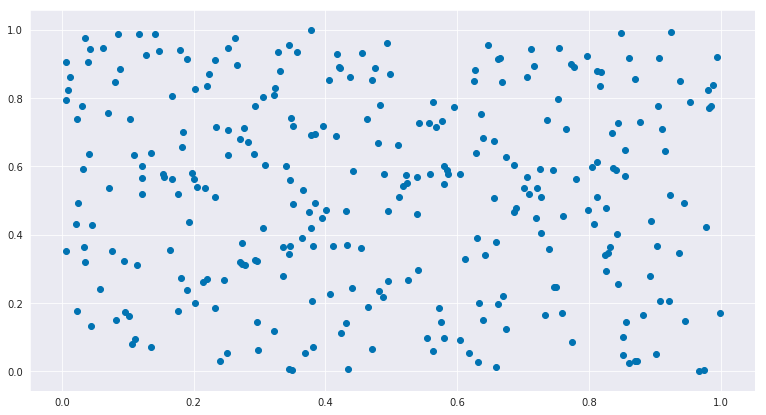

In [36]:
n_points = 300
dimensionality = 3
points = np.random.uniform(size=(n_points, dimensionality))
plt.scatter(points[:, 0], points[:, 1]);

In [37]:
sigma=0.2

In [38]:
G = graphs.NNGraph(points, NNtype='knn', k=2, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G.N} nodes, {G.Ne} edges')

300 nodes, 385 edges


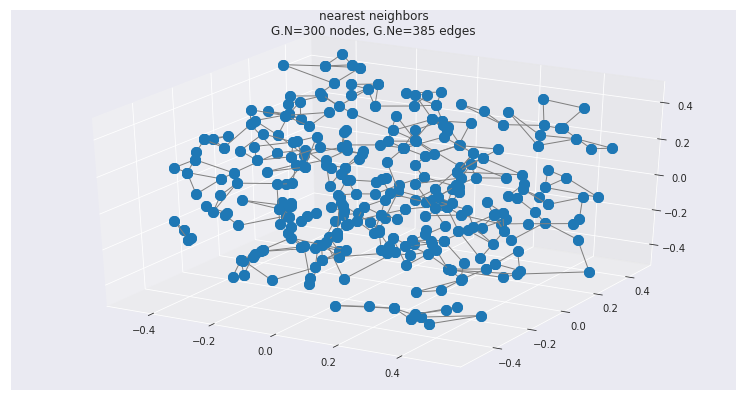

In [39]:
G.plot()

In [40]:
G = graphs.NNGraph(points, NNtype='radius', epsilon=0.1, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G.N} nodes, {G.Ne} edges')

300 nodes, 183 edges


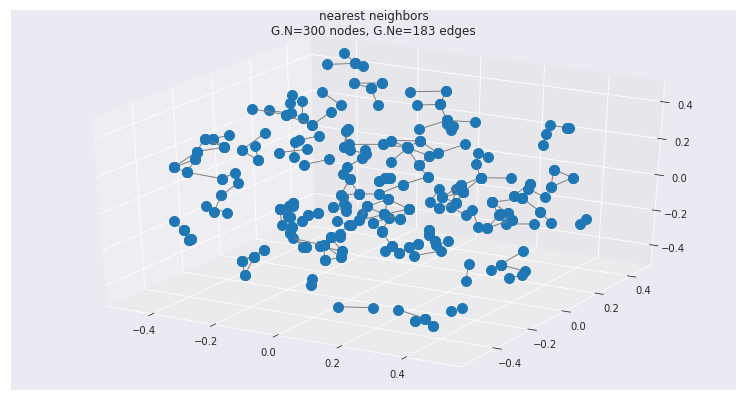

In [41]:
G.plot()

# Spectral Graph Theory - Fucking Cool

# A. Spectrum (Ei.Values) of a Graph

We consider here only undirected graphs, such that the Laplacian matrix is real symmetric, thus diagonalizable in an orthonormal eigenbasis
$$\mathbf{L}=\mathbf{U}\mathbf{\Lambda U}^\top,$$
where $\mathbf{U}=(\mathbf{u}_1|\ldots|\mathbf{u}_N)\in\mathbb{R}^{N\times N}$ is the matrix of orthonormal eigenvectors and $\mathbf{\Lambda} = \text{diag}(\lambda_1,\ldots,\lambda_N)$ is the diagonal matrix of associated sorted eigenvalues:
$$\lambda_1\leq\lambda_2\leq\ldots\leq\lambda_N.$$

Note: 
* $\lambda_1$ is necessarily $0$ and that $\lambda_2>0$ iff the graph is connected.
* The Laplacian matrix has very nice property: $$0\leq\lambda_1\leq\lambda_2\leq\ldots\leq\lambda_N\leq2.$$

2018-11-24 15:05:24,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 3.1622776601683795


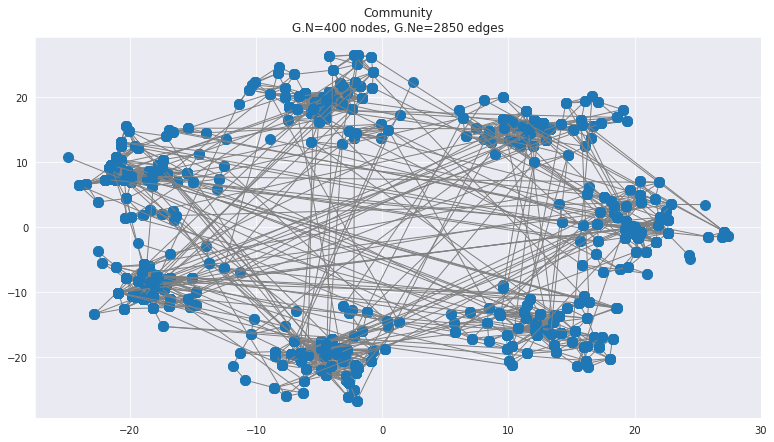

In [61]:
G = graphs.Community(N=400, Nc=7)
G.plot()
eig_val, U = sp.linalg.eigh(G.L.toarray())
#eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM') # used for SBM
#eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')

Use ```sp.linalg.eigh``` to diagonalize $\mathbf{L}$ because it is the eigensolver optimized for symmetric matrices. Also, ```sp.linalg.eigh``` cannot take sparse matrices as entries. For sparse matrices, optimized eigensolvers exist to obtain the first few eigenvalues and eigenvectors, such as 

```eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')```

Option```which='SM'``` for smallest magnitude search, and ```which='LM'``` for largest magnitude search.

```eigsh``` is nevertheless only made to compute only a few eigenvectors. You will quickly see the utility of ```sp.sparse.linalg.eigsh(G.L, k=10, which='SM')``` versus ```sp.linalg.eigh(G.L.toarray())``` if you increase the size of the network to $10^4$ nodes or larger for instance.

In [53]:
np.finfo(float).resolution

1e-15

In [54]:
# G_nx = nx.from_numpy_matrix(G.A.toarray())
# sorted(nx.connected_components(G_nx),key = len, reverse=True)

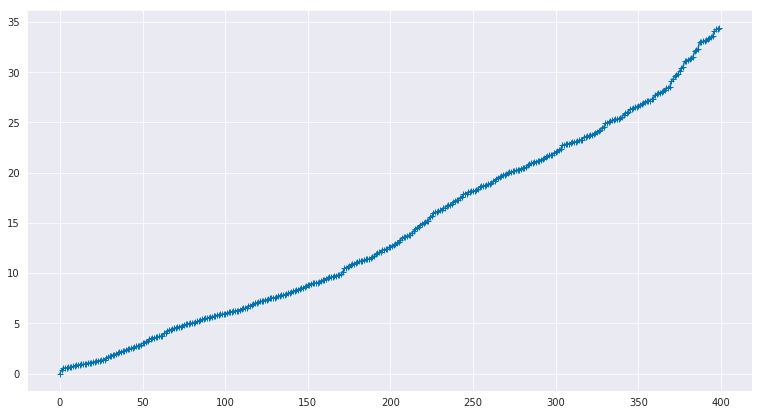

In [62]:
plt.plot(eig_val, '+-')

# B. SBM

The Stochastic Block Model (SBM) is a latent variable model of structured random graphs. 
* The set of $N$ nodes is partitioned in $k$ blocks $B_1, \ldots, B_k$ : $\cup_{i} B_i = \{1,\ldots,N\}$ and $\forall i\neq j, B_i\cap B_j = \emptyset$.
* Define a probability matrix $\mathbf{P}\in\mathbb{R}^{k\times k}$ such that $P_{ij}$ is the probability of connection between a node in $B_i$ and a node in $B_j$. 
* To generate an instance of SBM: for each pair of nodes in the graph, draw a Bernoulli random variable of parameter corresponding to their respective blocks.

Relaxation: Suppose that all intra-block probabilities are set to $p_{\text{in}}$ and all inter-block probabilities are set to $p_{\text{out}}$. Also, we will consider only balanced SBMs (ie SBMs whose blocks have same size).

In the case of balanced SBMs, instead of the pair of parameters $(p_{\text{in}}, p_{\text{out}})$, consider the pair $(c,\epsilon)$ where $c$ is the average degree of the graph and $\epsilon = \frac{p_{\text{out}}}{p_{\text{in}}}$ is a measure of fuzziness: the larger $\epsilon$, the fuzzier the community structure. The relations between both pairs of parameters are:
 $$p_{\text{in}} = \frac{kc}{N-k+(k-1)\epsilon N}~~~\text{ and }~~~p_{\text{out}} = \frac{kc\epsilon}{N-k+(k-1)\epsilon N}$$

NOTE: for a fixed triplet $(\epsilon, N, k)$, $c$ is not a free parameter. 

**The classical inference SBM problem** is: given an instance of an SBM $G$, infer the blocks.

#### Impossibility threshold
In the balanced (ie: all blocks have the same size) and sparse (ie average degree $c=\mathcal{O}(1)$) case, the following phase transition has been shown ([Decelle et al.](https://arxiv.org/pdf/1109.3041.pdf), [Massoulié](https://arxiv.org/pdf/1311.3085.pdf), [Abbe et al.](https://arxiv.org/pdf/1503.00609.pdf)). For a given pair $(k, c)$, there exists a critical fuzziness $\epsilon_c$ such that as $N\rightarrow \infty$:
* if $\epsilon>\epsilon_c$, there exists no algorithm capable of extracting any structural information.
* if $\epsilon<\epsilon_c$, it is *theoretically* possible to retrieve some kind of structural information

with $\epsilon_c = \frac{c - \sqrt{c}}{c + \sqrt{c} (k-1)}$

In [40]:
N = 1000 # number of nodes
k = 5 # number of blocks
c = 20 # average degree

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 50 # this is a very strong block structure

pin = (k * c) / (N - k + (k - 1) * epsi * N)
pout = (k * c * epsi) / (N - k + (k - 1) * epsi * N)

z = np.tile(np.arange(k), (np.int(N/k),1))
truth = np.reshape(z.T, (N,1))[:,0] # the ground truth community assignment truth[i] is the community number of node i

G = graphs.StochasticBlockModel(N=N, k=k, z=truth, p=pin, q=pout)

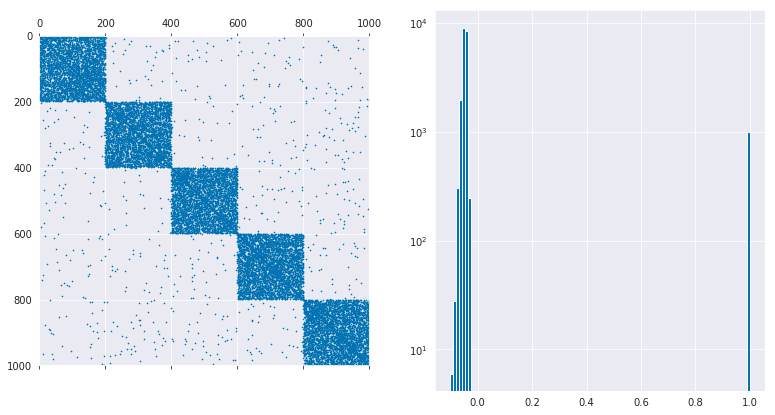

In [30]:
G.compute_laplacian('normalized')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6)
axes[1].hist(G.L.data, bins=100, log=True);

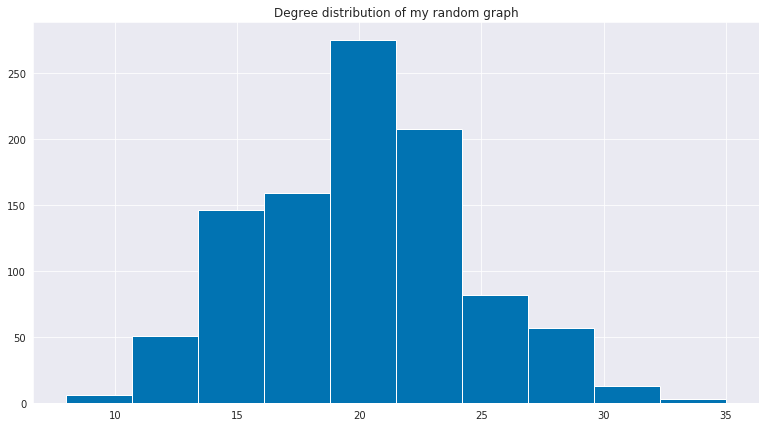

In [31]:
plt.hist(G.d)
plt.title('Degree distribution of my random graph');

In [32]:
np.int(N/k),1

(200, 1)

In [33]:
np.arange(k)

array([0, 1, 2, 3, 4])

In [17]:
#z = np.tile(np.arange(k), (np.int(N/k),1))


In [35]:
(N,1)

(1000, 1)

In [14]:
#z.T

In [16]:
#np.reshape(z.T, (N,1))

With ```epsi = epsi_c / 50```, ie, a very strong block structure, blocks appear even 'visually' with spring-based plotting algorithms:

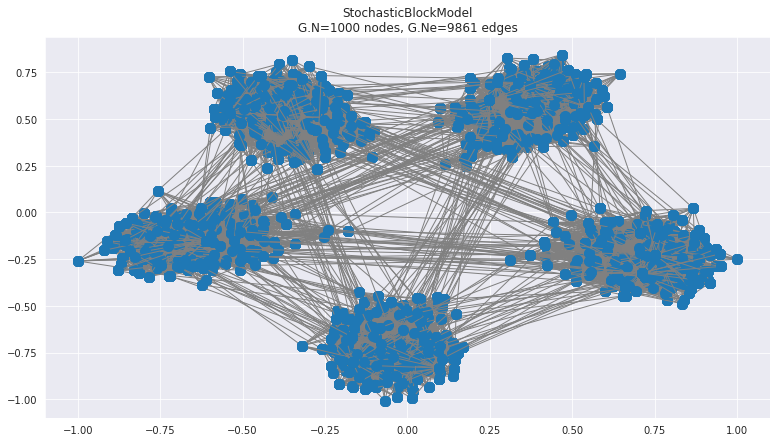

In [41]:
G.set_coordinates(kind='spring') #here with a spring based algorithm
G.plot()

# B. Ei.Gap

In [42]:
G.compute_fourier_basis()

In [43]:
eig_val, U = G.e, G.U

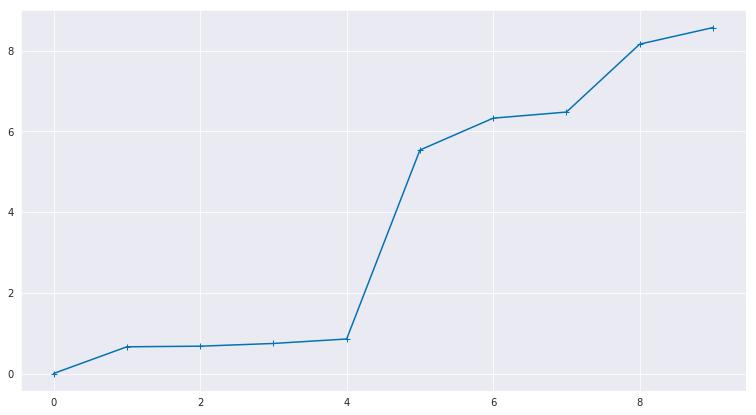

In [44]:
plt.plot(eig_val[:10], '+-')

The large gap between $\lambda_k$ and $\lambda_{k+1}$ is called the "spectral gap": it heuristically appears when there is a strong structure in $k+1$ communities (even though there exist some theoretical justifications)

Hence,there is a strong structure in $5$ communities

In [13]:
#U

In [46]:
len(U)

1000

In [48]:
len(U[0])

1000

In [12]:
#U[:,0]

In [50]:
len(U[:,0])

1000

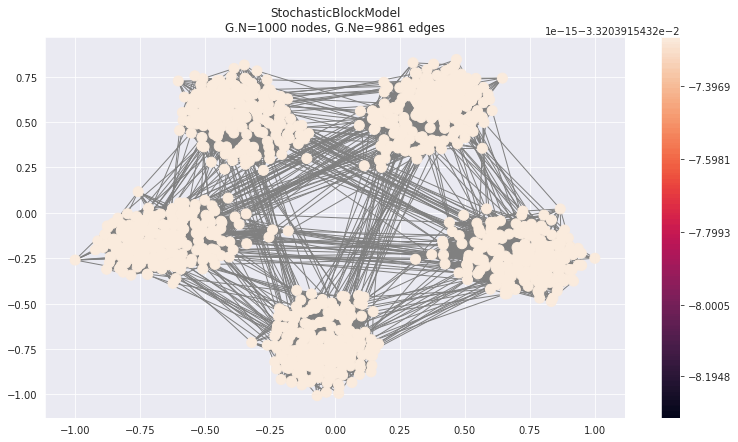

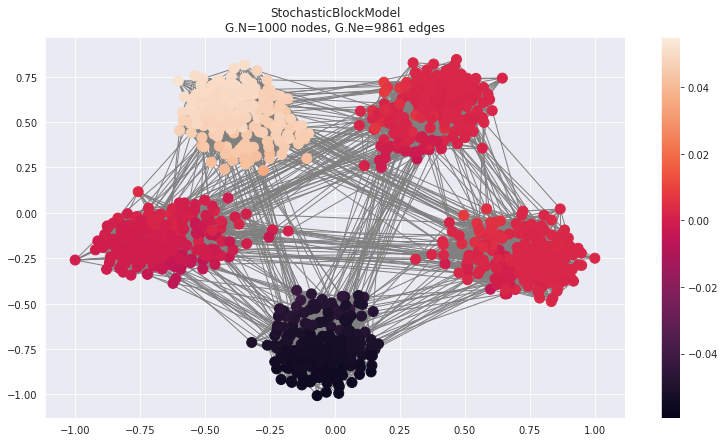

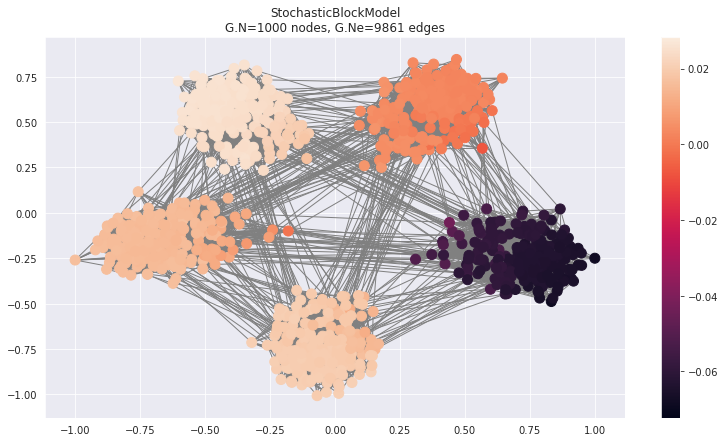

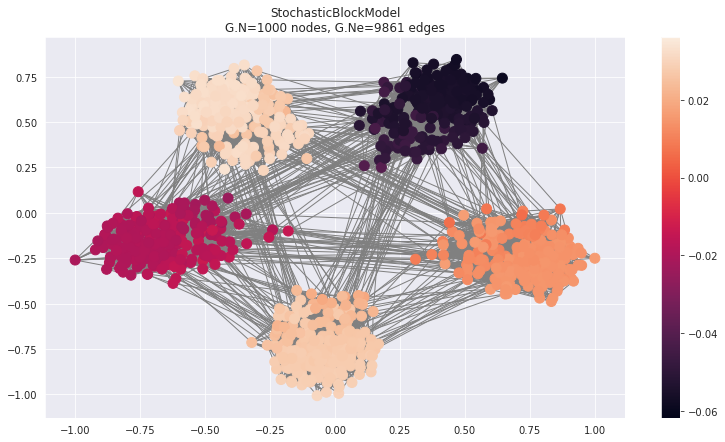

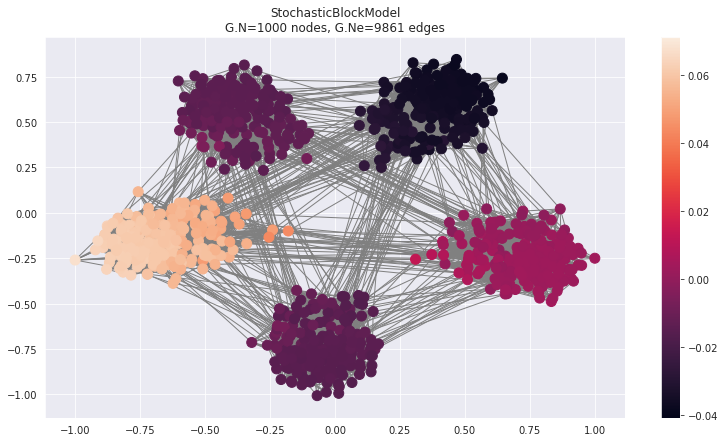

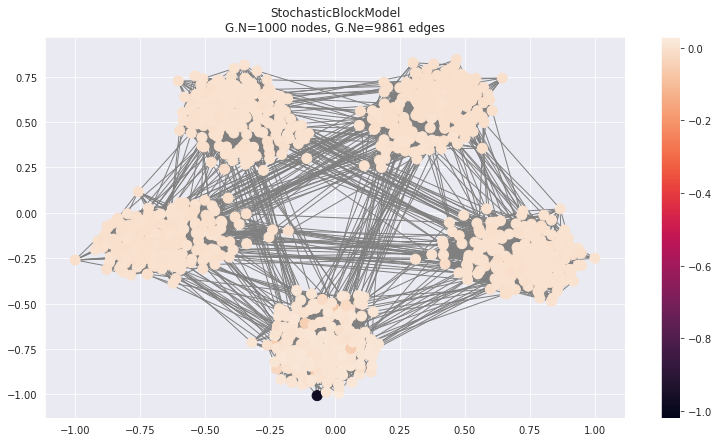

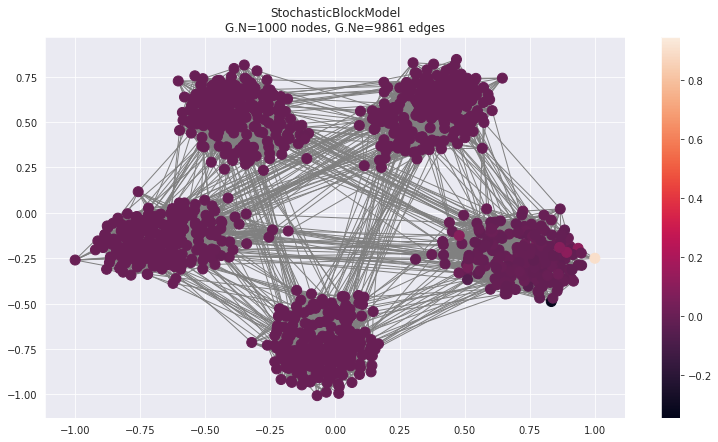

In [51]:
G.plot_signal(U[:,0])
G.plot_signal(U[:,1])
G.plot_signal(U[:,2])
G.plot_signal(U[:,3])
G.plot_signal(U[:,4])
G.plot_signal(U[:,5])
G.plot_signal(U[:,6])

Why is the 5th eigenvector so localized?


NOTE that:
$$\lambda_k=\mathbf{u}_k^\top\mathbf{L}\mathbf{u}_k=\sum_{i\sim j}\mathbf{W}_{ij} (u_k(i)-u_k(j))^2,$$
such that eigenvectors associated to low eigenvalues tend to be smooth with respect to any path in the network. In block-structured graphs, this usually means quasi-constant within each block. Also:
$$\mathbf{u}_2= \text{argmin}_{\mathbf{u}\in\mathbb{R}^N \text{  s.t.  }   \mathbf{u}_1^\top\mathbf{u}=0 \text{ and } \mathbf{u}^\top\mathbf{u}=1} ~~~\mathbf{u}^\top\mathbf{L}\mathbf{u}.$$
Because $\mathbf{u}_1=\frac{1}{\sqrt{N}}\mathbf{1}$ where $\mathbf{1}$ is the constant vector equal to $1$ (this is true in the case of the combinatorial Laplacian), this equation is equivalent to:
$$\mathbf{u}_2= \text{argmin}_{\mathbf{u}\in\mathbb{R}^N \text{s.t.} \sum_i u_2(i) = 0 \text{ and  }\sum_i u_2(i)^2 = 1} ~~~\mathbf{u}^\top\mathbf{L}\mathbf{u}.$$
In words: $\mathbf{u}_2$ is the normalized vector that minimizes local variation **AND** that has zero average. Similarly, $\mathbf{u}_3$ is the normalized vector that minimizes local variation **AND** that is orthogonal both to $\mathbf{u}_1$ and $\mathbf{u}_2$. Etc.

Spectral clustering takes advantage of this property.


Say we want to recover in which block belongs each node. The first eigenvector's information is useless (as long as we use the combinatorial Laplacian anyways) as it is constant. A solution is to plot each node $i$ in 2D with coordinates $(u_2(i), u_4(i))$:

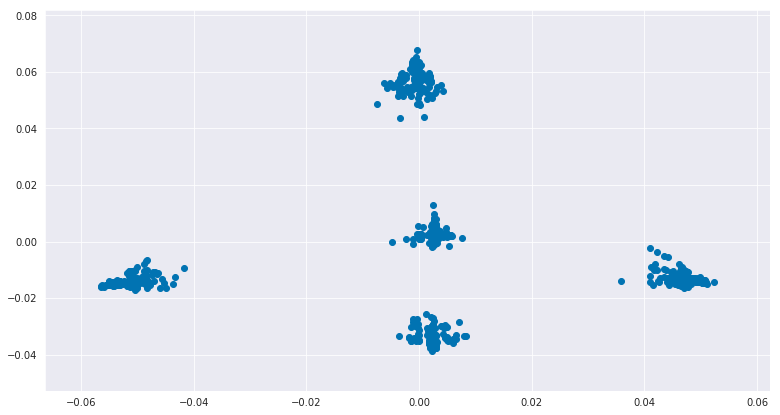

In [52]:
plt.figure()
plt.scatter(U[:,1], U[:,4])

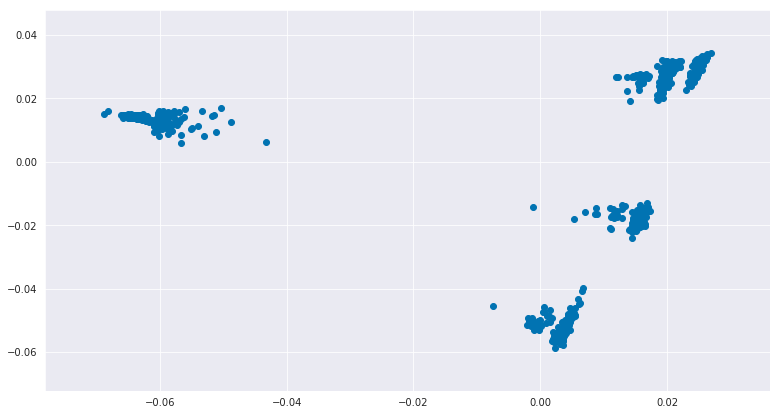

In [53]:
plt.figure()
plt.scatter(U[:,2],U[:,3])

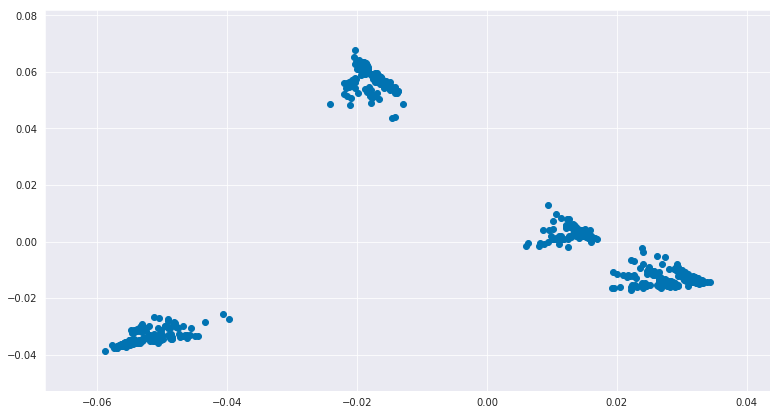

In [54]:
plt.figure()
plt.scatter(U[:,3],U[:,4])

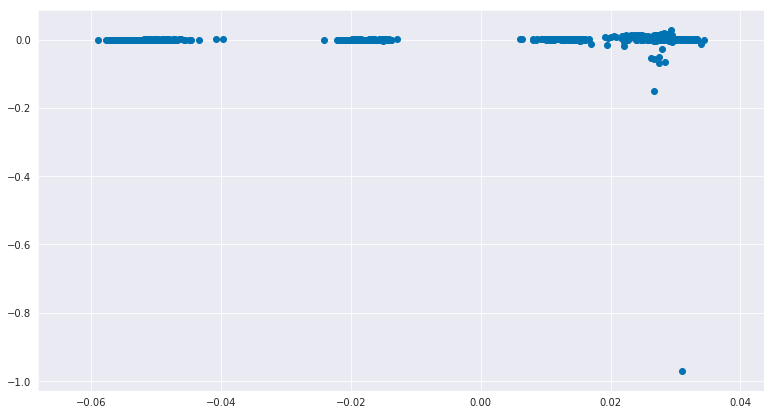

In [55]:
plt.figure()
plt.scatter(U[:,3],U[:,5])

U2 and U4 provides a better representation of each cluster

Look at ```plt.scatter(U[:,1], U[:,4], c=G.truth)```: the nodes in the same block are in the same 'blob' in this 2D plot! This observation is the basis of spectral-clustering-type algorithms. 

**TODO**
* In the last example, performing $k$-means in the $2D$ plane defined by $\mathbf{u}_1$ and $\mathbf{u}_4$ recovers the 5 block structures (the ground truth is in ```G.truth```). To measure performance,I use the function ```AR_index``` which computes the [Adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index) (both functions were already imported in the preamble)

* Plot the average performance of community mining with this spectral clustering algorithm on balanced SBMs versus the fuziness $\epsilon$. 

* Read ["A tutorial on spectral clustering" by U. von Luxburg](https://arxiv.org/pdf/0711.0189.pdf) to learn among other things that a degree-corrected version is in general preferable (using the normalized Laplacian instead of the combinatorial Lap for instance). For arguments to choose the "best" degree-correction, see ['Improved spectral community detection in large heterogeneous networks' by Tiomoko Ali and Couillet](http://www.jmlr.org/papers/volume18/17-247/17-247.pdf).

In [105]:
communities = [100, 150, 80]
G = graphs.Community(N=330, Nc=3, comm_sizes=communities, seed=1)

2018-11-25 19:09:32,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 3.013793467093005


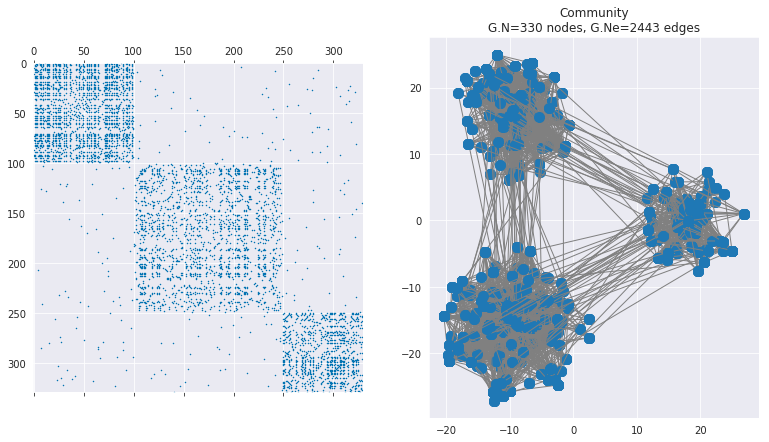

In [73]:
fig, axes = plt.subplots(1, 2)
axes[0].spy(G.W, markersize=0.5)
G.set_coordinates('community2D')
G.plot(ax=axes[1])

Use the combinatorial Laplacian $L = D - W$.
OR the normalized Laplacian $\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{W} \mathbf{D}^{-1/2}$.

/home/hugh/anaconda3/envs/graph-tool/lib/python3.6/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


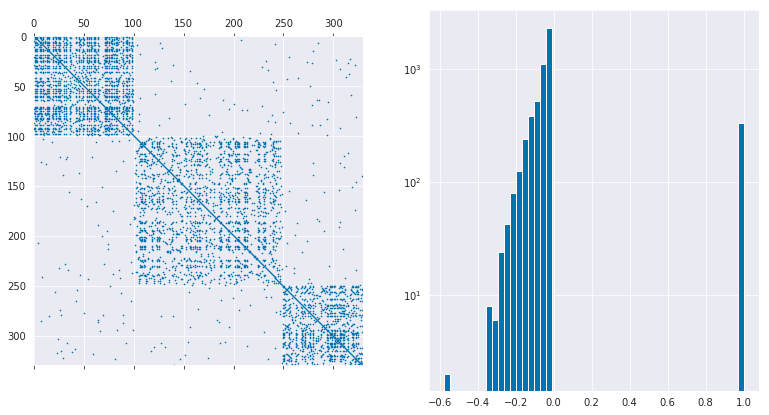

In [106]:
G.compute_laplacian('normalized')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6)
axes[1].hist(G.L.data, bins=50, log=True);

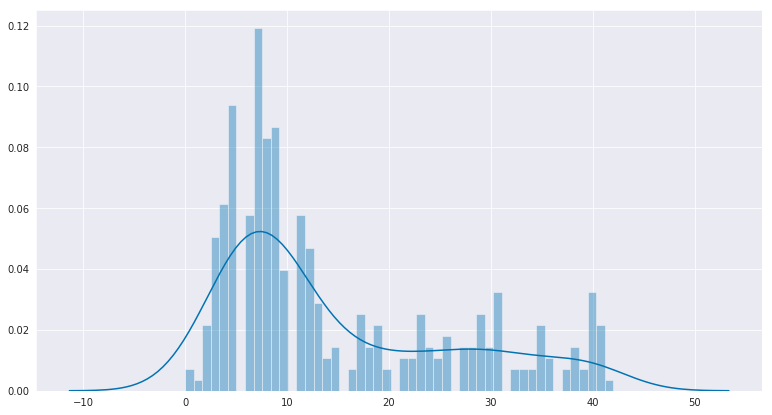

In [78]:
sns.distplot(G.d, 50)

# C. Spectral Graph Signal

A graph signal is a function $\mathcal{V} \rightarrow \mathbb{R}$ that associates a value to each node $v \in \mathcal{V}$ of a graph. The signal values can be represented as a vector $f \in \mathbb{R}^N$ where $N = |\mathcal{V}|$ is the number of nodes in the graph.

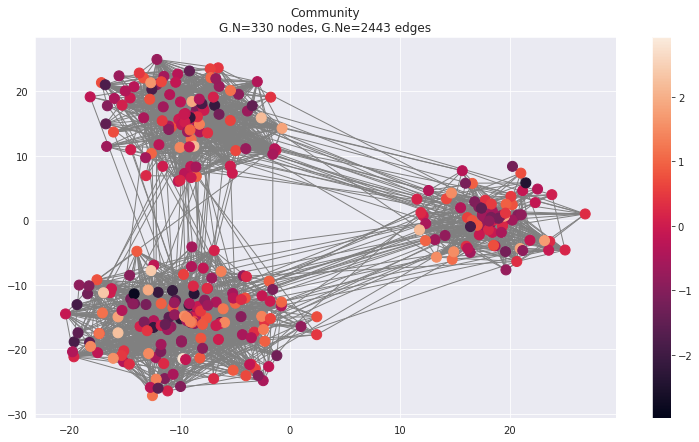

In [82]:
signal = np.random.normal(size=G.N)
G.plot_signal(signal)

## 1 Gradient and divergence

The gradient $\nabla_\mathcal{G} \ f$ of the signal $f$ on the graph $\mathcal{G}$ is a signal on the edges defined as

$$(\nabla_\mathcal{G})_{(i,j)} \ f = \sqrt{W_{ij}} (f_i - f_j)$$

The differential operator $\mathbf{D} \in \mathbb{R}^{|\mathcal{E}| \times N}$ is defined such as $\mathbf{L} = \mathbf{D}^\intercal \mathbf{D}$. It can be computed with the PyGSP: 

In [92]:
G.compute_differential_operator()
print(G.D.shape)

(2443, 330)


In [83]:
G.D

<2443x330 sparse matrix of type '<class 'numpy.float64'>'
	with 4886 stored elements in Compressed Sparse Column format>

In [93]:
gradient = G.D @ signal
assert gradient.size == G.Ne
gradient

array([ 0.07905239,  0.12335511,  0.04430272, ..., -0.01430356,
       -0.33874577, -0.33978507])

The gradient of a signal $\mathbf{x}$ is then given by
$$\dot{\mathbf{x}} = \nabla_{G} \, \mathbf{x} = \mathbf{D} \mathbf{x} \in \mathbb{R}^{|\mathcal{E}|}.$$

Its value on the edge $(i,j) \in \mathcal{E}$ is given by
$$\dot{\mathbf{x}}[(i,j)] = \sqrt{\mathbf{W}[i,j]} \, (\mathbf{x}[i] - \mathbf{x}[j]).$$

Similarly, we can compute the divergence of an edge signal, which is again a signal on the nodes.

$$(\operatorname{div}_\mathcal{G} x)_i = \sum_{j \sim i} \sqrt{W_{ij}} x_{(i,j)}$$

Similarly, the divergence of $\dot{\mathbf{x}}$ is given by
$$\operatorname{div} \dot{\mathbf{x}} = \mathbf{D}^\intercal \dot{\mathbf{x}} = \mathbf{D}^\intercal \mathbf{D} \mathbf{x} = \mathbf{L} \mathbf{x} \in \mathbb{R}^N.$$

It is a graph signal which value at node $i \in \mathcal{V}$ is given by
$$
\begin{align*}
(\operatorname{div} \dot{\mathbf{x}}) [i] &= \sum_{i \sim j} \sqrt{\mathbf{W}[i,j]} \, \dot{\mathbf{x}}[(i,j)] \\
&= \sum_{i \sim j} \mathbf{W}[i,j] \, (\mathbf{x}[i] - \mathbf{x}[j]) \\
&= (\mathbf{L} \mathbf{x})[i].
\end{align*}
$$

Note that the above derivations are for the combinatorial Laplacian. For the normalized Laplacian, replace $\W$ by $\mathbf{D}^{-1/2} \mathbf{W} \mathbf{D}^{-1/2}$. As its name implies, the normalized Laplacian is simply a normalization of the edge weights.

In [94]:
divergence = G.D.T @ gradient
assert divergence.size == G.N

In [88]:
np.linalg.norm(G.L @ x - divergence)

22.801681083913603

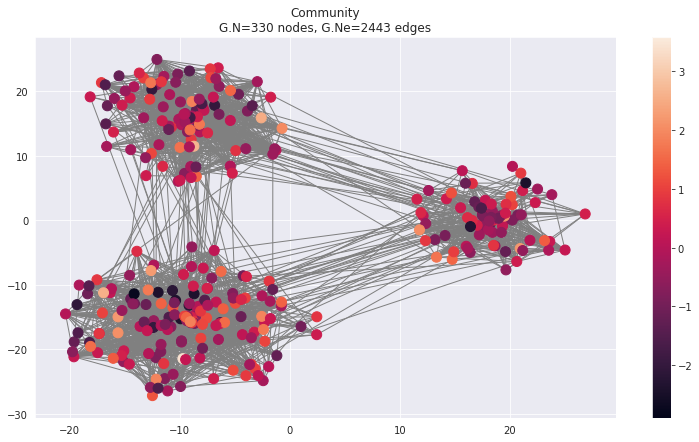

In [89]:
G.plot_signal(divergence)

The Laplacian operator is indeed the divergence of the gradient

In the PyGSP, the gradient and divergence can be computed more efficiently with `G.grad()` and `G.div()`.

In [96]:
# np.testing.assert_allclose(gradient, G.grad(x))
# np.testing.assert_allclose(divergence, G.div(gradient))

## 2. Smoothness

The smoothness of a signal can be computed by the quadratic form

$$ f^\intercal L f = \sum_{i \sim j} W_{ij} (f_i - f_j)^2 $$

Is our random signal smooth? Our intuition certainly says no. Let's verify by computing the norm of the gradient:
$$\| \nabla_\mathcal{G} \, \mathbf{x} \|_2^2 = \langle \mathbf{D} \mathbf{x}, \mathbf{D} \mathbf{x} \rangle = \mathbf{x}^\intercal \mathbf{L} \mathbf{x} = \sum_{i \sim j} \mathbf{W}[i,j] (\mathbf{x}[i] - \mathbf{x}[j])^2.$$

Note that we are normalizing by the norm of the signal, so that its energy does not influence our computation.

In [98]:
signal.T @ G.L @ signal

320.5882521207636

In [99]:
signal.T @ G.L @ signal/ np.linalg.norm(signal)**2

1.0036013670813397

Let's compare it with the partitioning function:
$$ x[i] =
\begin{cases}
    -1 &\text{if } i \in S_1, \\
    0  &\text{if } i \in S_2, \\
    1  &\text{if } i \in S_3,
\end{cases}
$$
where $S_i$ is the set of nodes in partition $i$.

In [100]:
x = np.zeros(G.N)
x[:communities[0]] = -1 * np.ones(communities[0])
x[-communities[-1]:] = 1 * np.ones(communities[-1])

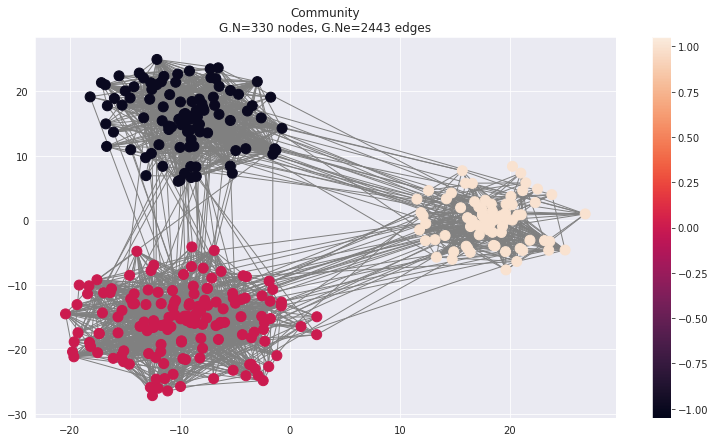

In [101]:
G.plot_signal(x)

In [102]:
x.T @ G.L @ x / np.linalg.norm(x)**2

0.13755453849647337

**NOTE** the later normalized smoothness is a lot smooth than randomly generated signals

In [107]:
# G.compute_fourier_basis()
# eig_val, U = G.e, G.U
eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')

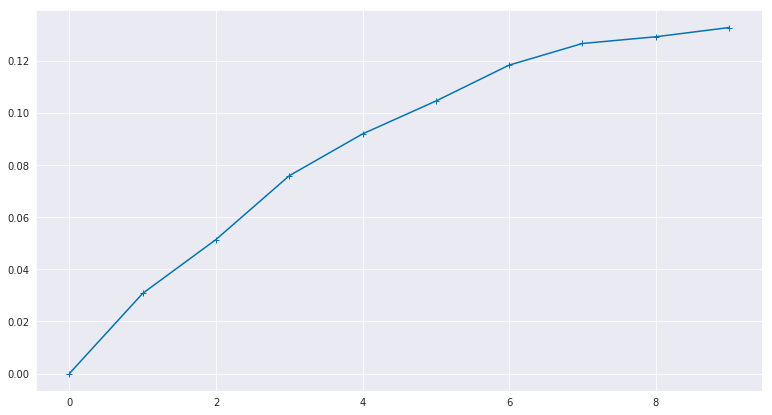

In [108]:
plt.plot(eig_val[:10], '+-')

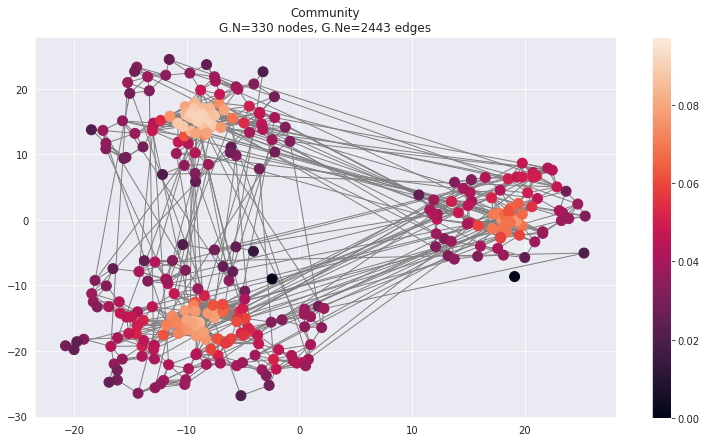

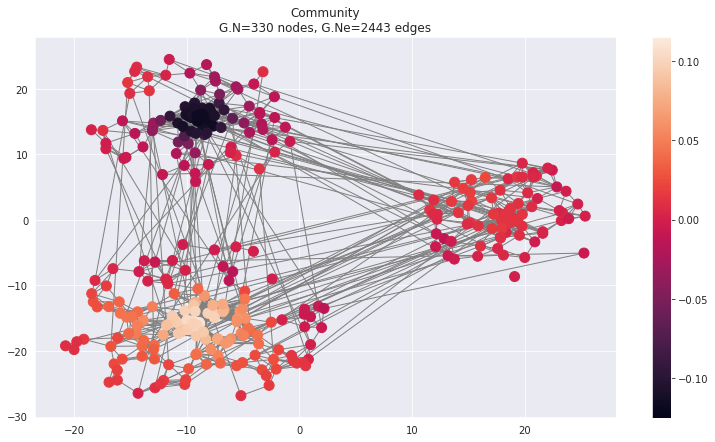

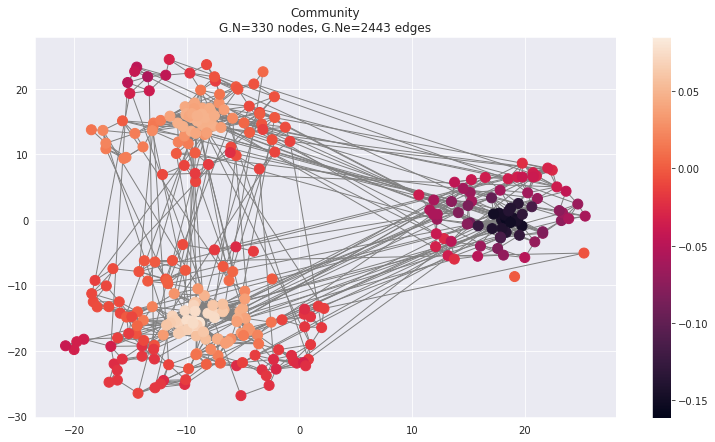

In [109]:
G.plot_signal(U[:,0])
G.plot_signal(U[:,1])
G.plot_signal(U[:,2])

On a graph that already have signals intergrated to it, we cannot use the eigen gap theorem on this. Eigen map only applies with raw graph

#### THE BELOW PLOT IS THERE BECAUSE IT LOOKS COOL :D

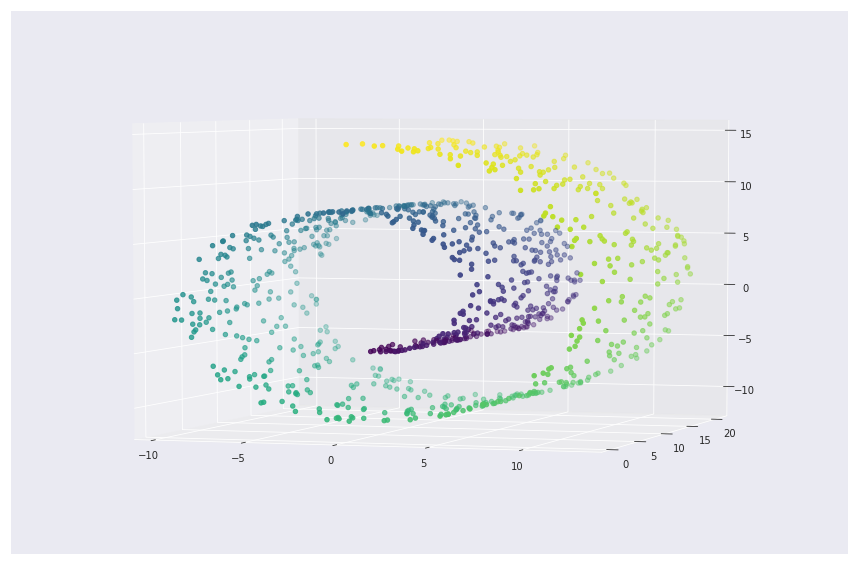

In [5]:
# Swiss Roll

Axes3D

n_points = 1000
X, color = datasets.make_swiss_roll(n_points, random_state=0)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap='viridis')
ax.view_init(4, -72)

# FOURIER BASIS

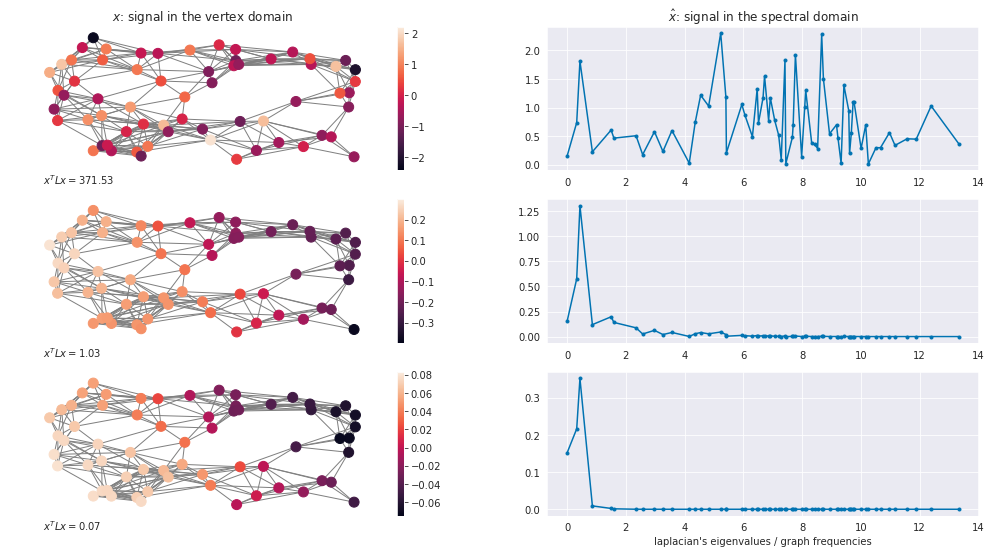

In [19]:
G = graphs.Sensor(seed=42)
G.compute_fourier_basis()

taus = [0, 10, 50]
fig, axes = plt.subplots(len(taus), 2, figsize=(17, 9))

x0 = np.random.RandomState(1).normal(size=G.N)
for i, tau in enumerate(taus):
    g = filters.Heat(G, tau)
    x = g.filter(x0).squeeze()
    x_hat = G.gft(x).squeeze()
    
    G.plot_signal(x, ax=axes[i, 0])
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('')
    axes[i, 0].text(0, -0.2, '$x^T L x = {:.2f}$'.format(x.T @ G.L @ x))
    
    axes[i, 1].plot(G.e, np.abs(x_hat), '.-')
    
axes[0, 0].set_title(r'$x$: signal in the vertex domain')
axes[0, 1].set_title(r'$\hat{x}$: signal in the spectral domain')
axes[-1, 1].set_xlabel("laplacian's eigenvalues / graph frequencies");

In [26]:
G = graphs.Minnesota(365)
G.compute_fourier_basis()

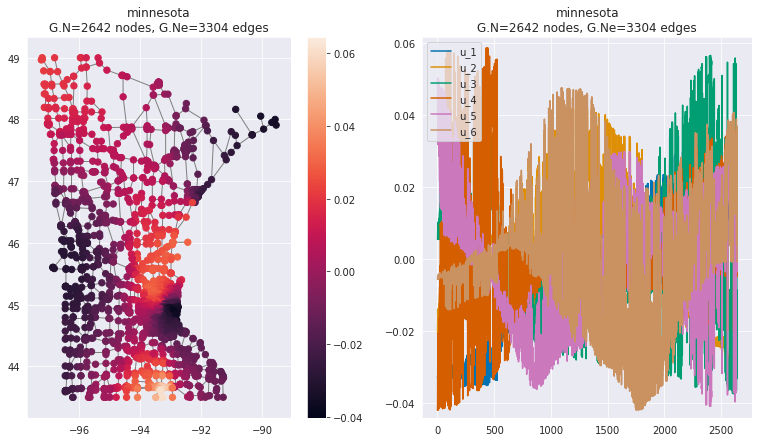

In [27]:
fig, axes = plt.subplots(1, 2)
G.plot_signal(G.U[:, 7], ax=axes[0])

G.set_coordinates('line1D')
G.plot_signal(G.U[:, 1:7], ax=axes[1])
axes[1].legend(['u_{}'.format(i) for i in range(1, 7)])

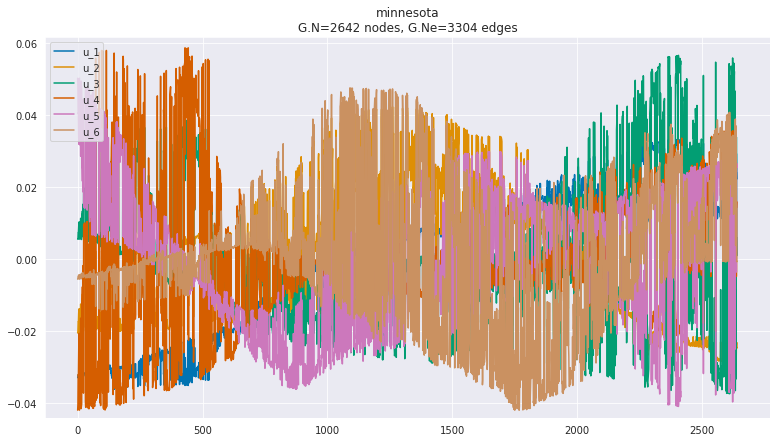

In [30]:
G.set_coordinates('line1D')
G.plot_signal(G.U[:, 1:7])
plt.legend(['u_{}'.format(i) for i in range(1, 7)])

In [31]:
G = graphs.Sensor(365)
G.compute_fourier_basis()

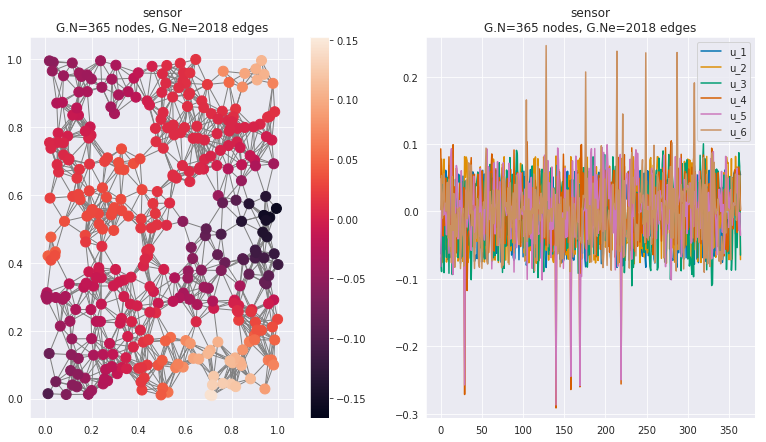

In [32]:
fig, axes = plt.subplots(1, 2)
G.plot_signal(G.U[:, 7], ax=axes[0])

G.set_coordinates('line1D')
G.plot_signal(G.U[:, 1:7], ax=axes[1])
axes[1].legend(['u_{}'.format(i) for i in range(1, 7)])

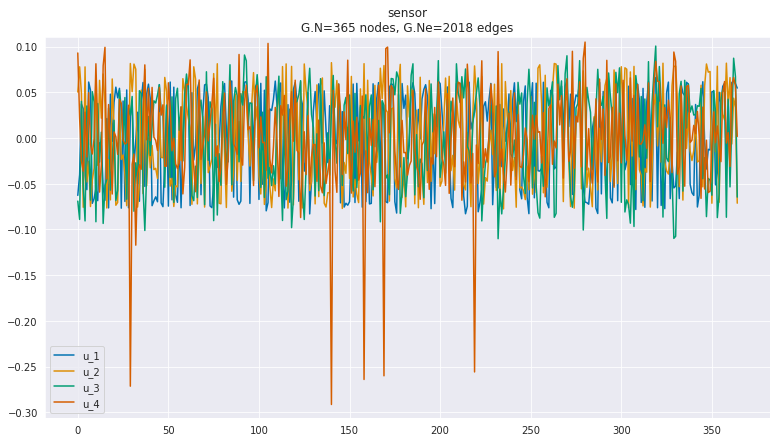

In [34]:
G.set_coordinates('line1D')
G.plot_signal(G.U[:, 1:5])
plt.legend(['u_{}'.format(i) for i in range(1, 5)])

**So , Graph is basically an object in space that is contructed from a set of nodes that vibrate with each other with some fundamental modes/frequencies, which are given by the ei.vectors of the Laplacian matrix. pretty cool eh?! :)**